In [1]:
library(dplyr)
library(tidyverse)
library(reshape2)
library(gridExtra)
library(grid)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.5     ✔ stringr 1.4.0
✔ tidyr   1.1.2     ✔ forcats 0.5.0
✔ readr   1.4.0     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
code_dir <- getwd()
tool_dir <- unlist(strsplit(code_dir,"/"))
tool_dir <- head(tool_dir, length(tool_dir)-1)
tool_dir <- paste(c(tool_dir, "tools"), collapse="/")
source(file.path(tool_dir, "pl_functions.R"))
base_dir <- gsub("/plotting_codes", "", code_dir)
base_dir


── Column specification ────────────────────────────────────────────────────────
cols(
  gs_name = col_character(),
  type = col_character(),
  use = col_character(),
  plot_use = col_character(),
  abbr = col_character(),
  order = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  gs_name = col_character(),
  gene_symbol = col_character()
)




[1] "/media/pipkin/ROCKET-PRO/CD8_DEV_SC"

In [3]:
exp_name <- "0_Acute-Chronic"
analysis_name <- c("0", "resampled") 

use.path <- file.path(base_dir, '9_Figures', exp_name, 
                      paste(analysis_name, collapse="_"),
                      'node_plots')
dir.create(use.path, showWarnings = FALSE, recursive=TRUE)
setwd(use.path)

## Proprocess

In [5]:
#####---------- Pre-process paga connection file
if (FALSE) {
  paga.out.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga'
  paga.conn.file <- "paga_connect.csv"
  paga.conn.file <- file.path(paga.out.dir, paga.conn.file)
  paga.conn.file.long <- gsub(".csv", "_long.csv", basename(paga.conn.file))
    
  new_names <- file.path(base_dir,'/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/pt_ordered_cluster_avg.csv')
  new_names_df <- read_csv(new_names) %>% dplyr::select(one_of(c('louvain', 'louvain_new_label')))
    
  #--- Read input
  paga.conn.tb <- read_csv(paga.conn.file)
  paga.conn.tb <- paga.conn.tb %>% melt(id.vars="X1") # Melt wide to long
  colnames(paga.conn.tb) <- c("From", "To", "Conn")
  #--- Remove duplicates (x_y & y_x keep one only)
  paga.conn.tb$From <- as.numeric(paga.conn.tb$From)
  paga.conn.tb$To <- as.numeric(as.character(paga.conn.tb$To))
  paga.conn.tb <- paga.conn.tb %>% rowwise() %>% mutate(fromto = paste(as.character(sort(c(From, To))), collapse="_"))
  paga.conn.tb$From <- NULL
  paga.conn.tb$To <- NULL
  paga.conn.tb <- paga.conn.tb %>% distinct()
  #--- Separate x_y into x y
  paga.conn.tb <- paga.conn.tb %>% separate(fromto, c("node1", "node2"), sep="_")
  paga.conn.tb$node1 <- as.numeric(paga.conn.tb$node1)
  paga.conn.tb$node2 <- as.numeric(paga.conn.tb$node2)
  paga.conn.tb <- paga.conn.tb %>% filter(Conn > 0)
  #--- Convert new names
  node1_df <- new_names_df
  colnames(node1_df) <- c("node1", "node1_new") 
  node2_df <- new_names_df
  colnames(node2_df) <- c("node2", "node2_new") 
  paga.conn.tb <- paga.conn.tb %>% 
    left_join(node1_df) %>% left_join(node2_df) 
  colnames(paga.conn.tb) <- c("Conn", "node1_old", "node2_old", "node1", "node2")
  
  #--- Save
  write_csv(paga.conn.tb, paga.conn.file.long)
}

# Get coordinates for edges
if (FALSE) {
  paga.out.dir <- '/media/pipkin/ROCKET-PRO/CD8_DEV_SC/0_Acute-Chronic/1_Scanpy/0_Scanpy_out_resampled/0_Acute-Chronic_paga'
  paga.pos.file <- "paga_pos.csv"
  paga.pos.file <- file.path(paga.out.dir, paga.pos.file)
  paga.conn.file.coor <- gsub(".csv", "_coor.csv", paga.conn.file.long)

  new_names <- file.path(base_dir,'/0_Acute-Chronic/2_scVelo/0_scVelo_out_resampled/pt_ordered_cluster_avg.csv')
  new_names_df <- read_csv(new_names) %>% dplyr::select(one_of(c('louvain', 'louvain_new_label')))
    
  paga.conn.file.long <- "paga_connect_long.csv"
  paga.pos.tb <- read_csv(paga.pos.file)
  paga.conn.tb <- read_csv(paga.conn.file.long)
  
  #--- Merge dataframe with connection & coordinates
  colnames(paga.pos.tb) <- c("node1_old", "x1", "y1")
  paga.conn.tb <- paga.conn.tb %>% left_join(paga.pos.tb)
  colnames(paga.pos.tb) <- c("node2_old", "x2", "y2")
  paga.conn.tb <- paga.conn.tb %>% left_join(paga.pos.tb)
  write_csv(paga.conn.tb, paga.conn.file.coor)
    
  #--- Convert node position dataframe to new name
  paga.pos.file.new <- "paga_pos_new.csv"
  colnames(paga.pos.tb) <- c('louvain', 'x', 'y')
  paga.pos.tb <- paga.pos.tb %>% left_join(new_names_df)
  colnames(paga.pos.tb) <- c("louvain_old", "x", "y", "louvain")
  write_csv(paga.pos.tb, paga.pos.file.new)
}

# 0. Read input

In [8]:
paga.conn.tb <- read_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/node_plots/paga_connect_long_coor.csv')
paga.pos.tb <- read_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/0_resampled/node_plots/paga_pos_new.csv')
paga.conn.tb <- paga.conn.tb %>% filter(Conn > 0.25)


── Column specification ────────────────────────────────────────────────────────
cols(
  Conn = col_double(),
  node1_old = col_double(),
  node2_old = col_double(),
  node1 = col_character(),
  node2 = col_character(),
  x1 = col_double(),
  y1 = col_double(),
  x2 = col_double(),
  y2 = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  louvain_old = col_double(),
  x = col_double(),
  y = col_double(),
  louvain = col_character()
)




# 1. Plot 

*Different subset data reference plot*

In [16]:
size.col.df <- read_csv('/media/pipkin/ROCKET-PRO/CD8_DEV_SC/9_Figures/0_Acute-Chronic/nodeplot_size_color.csv')

plot.all.tb <- size.col.df %>% left_join(by= 'louvain',paga.pos.tb)
plot.all.tb$louvain <- factor(plot.all.tb$louvain, levels=plot.all.tb$louvain)

conds <- colnames(size.col.df)
conds <- tail(conds, length(conds)-2)

for (i in conds) {
    plot.use.tb <- plot.all.tb %>% select(one_of(c("x", "y", "louvain", "colors", i)))
    colnames(plot.use.tb) <- c('x', 'y', 'Group', 'col', 'size')
    conn_plot_col_size(plot.use.tb, paga.conn.tb, i, 'white', FALSE) 
}

Parsed with column specification:
cols(
  louvain = col_character(),
  colors = col_character(),
  all = col_double(),
  act = col_double(),
  act_Arm = col_double(),
  act_Cl13 = col_double(),
  Arm = col_double(),
  Cl13 = col_double()
)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


*Pair wise comparison scheme node plot*

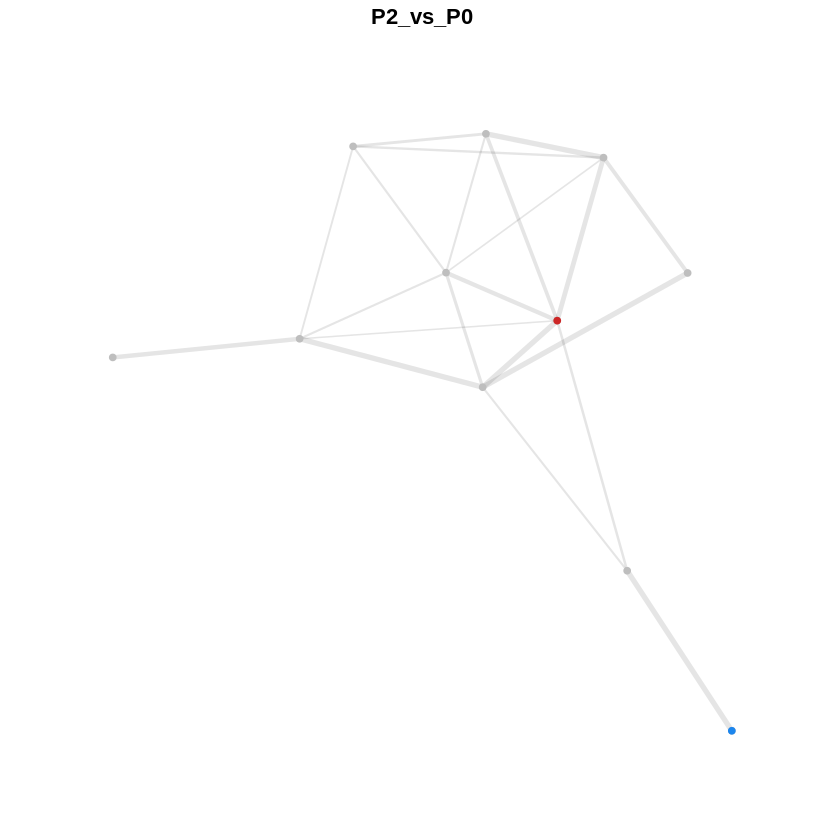

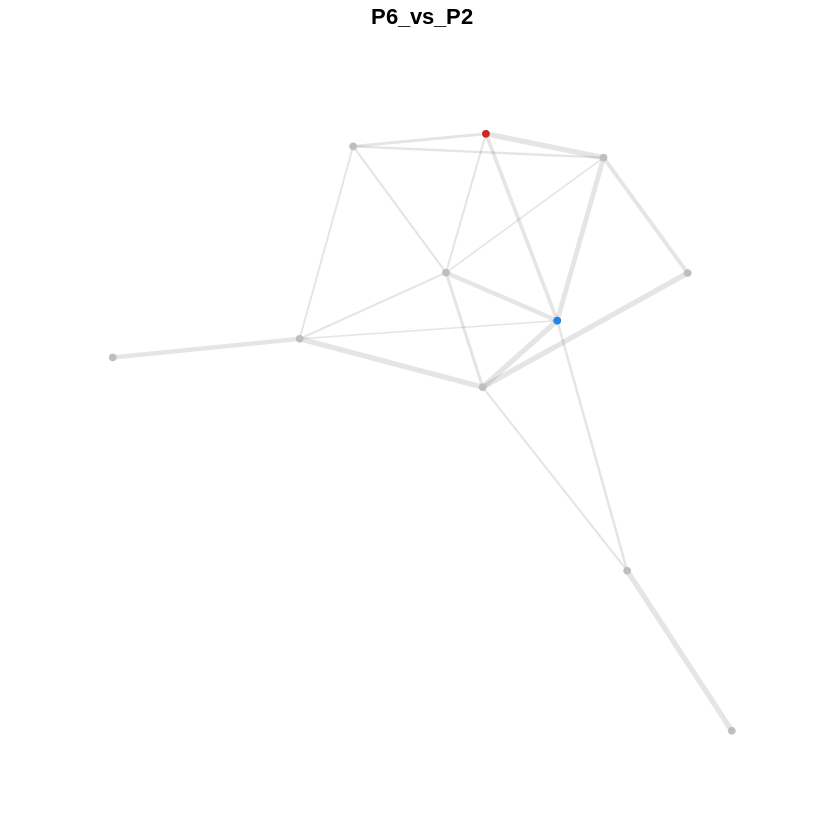

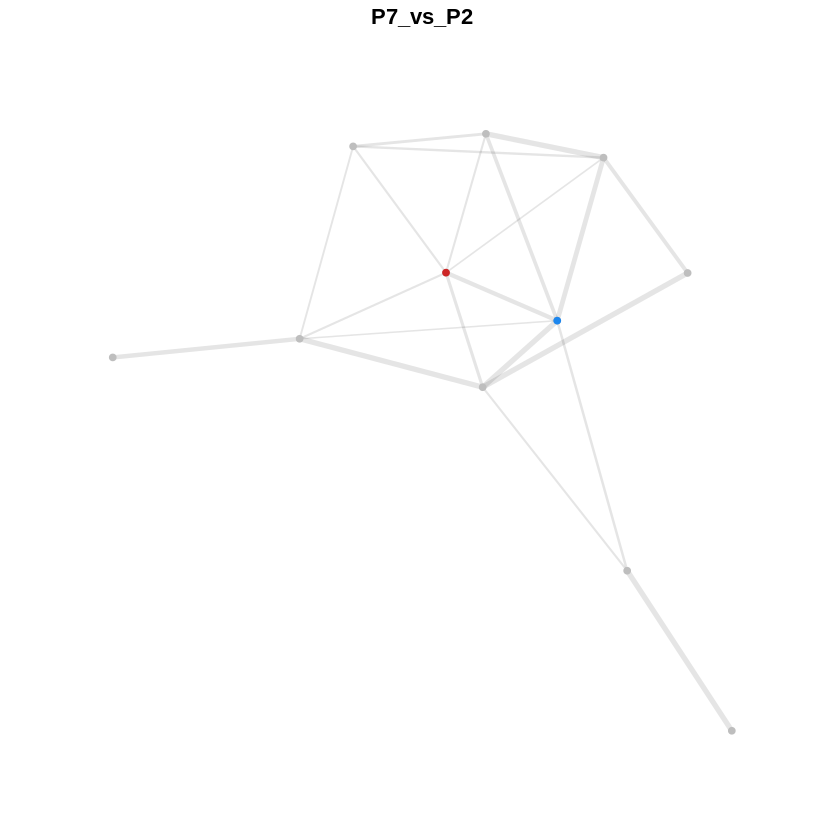

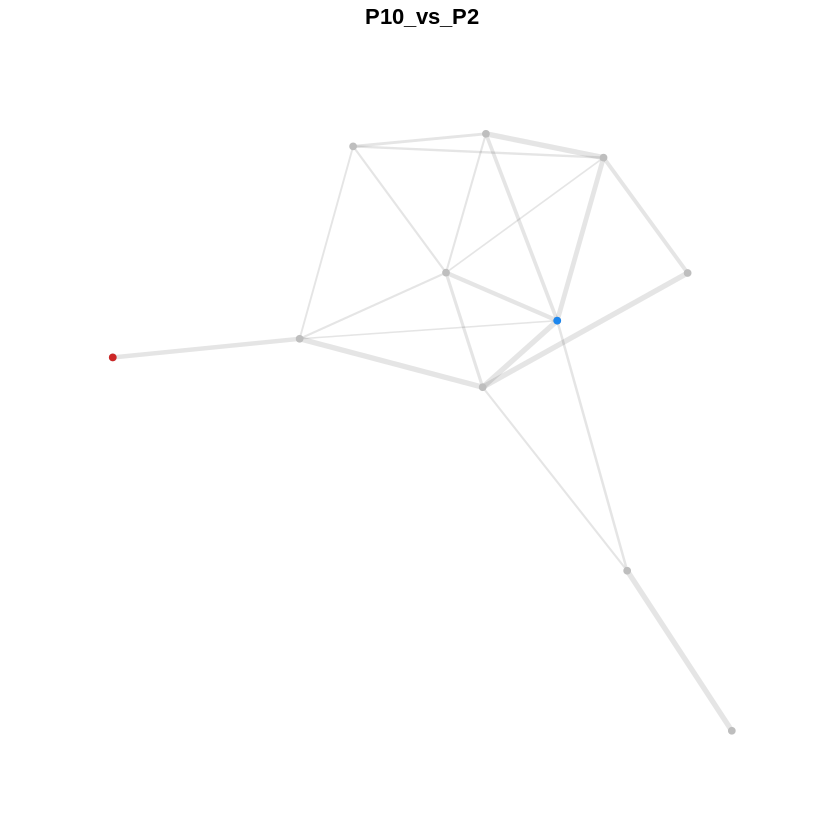

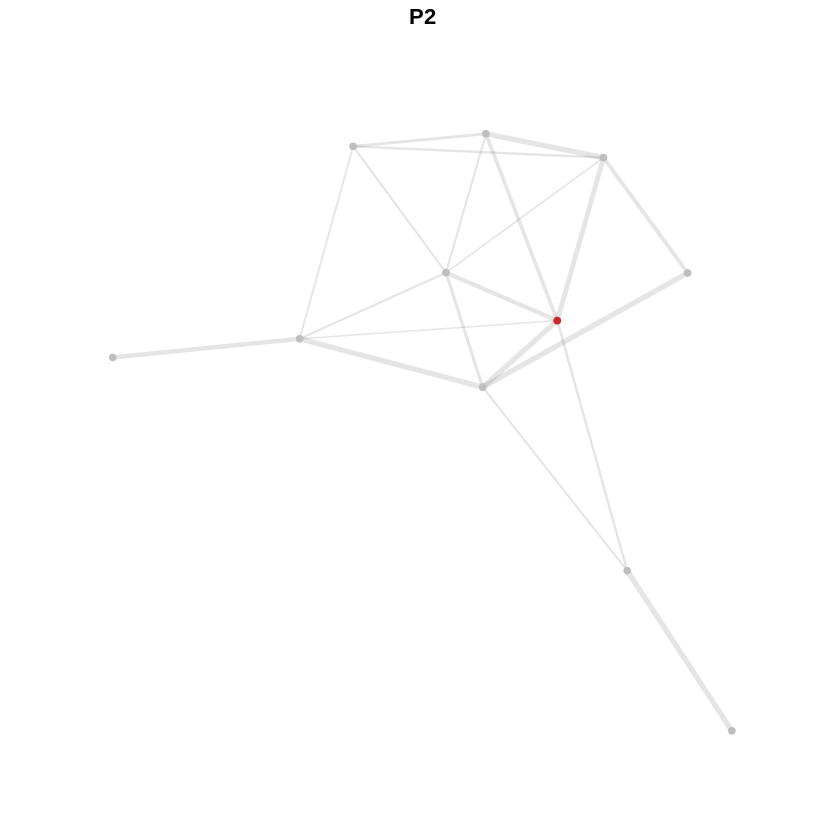

In [54]:
plot.pos.tb <- paga.pos.tb %>% mutate(Group=louvain) %>% select(one_of(c("x", "y", "Group")))

comparison <- c("P2", "P0")
conn_plot_comp(plot.pos.tb, paga.conn.tb, comparison, "white", FALSE)

comparison <- c("P6", "P2")
conn_plot_comp(plot.pos.tb, paga.conn.tb, comparison, "white", FALSE)

comparison <- c("P7", "P2")
conn_plot_comp(plot.pos.tb, paga.conn.tb, comparison, "white", FALSE)

comparison <- c("P10", "P2")
conn_plot_comp(plot.pos.tb, paga.conn.tb, comparison, "white", FALSE)

comparison <- c("P2")
conn_plot_comp(plot.pos.tb, paga.conn.tb, comparison, "white", FALSE)

## Seperate ARM / Cl13 GSEA output

In [13]:
wk_dir <- file.path(base_dir, '/9_Figures/0_Acute-Chronic/0_resampled/louvain_celltype_general_withNAV_node_plot')
setwd(wk_dir)
source(file.path(tool_dir, "pl_functions.R"))


── Column specification ────────────────────────────────────────────────────────
cols(
  gs_name = col_character(),
  type = col_character(),
  use = col_character(),
  plot_use = col_character(),
  abbr = col_character(),
  order = col_double()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  gs_name = col_character(),
  gene_symbol = col_character()
)




In [14]:
gsea.out.file <- 'louvain_celltype_general_withNAV_gsea_all.csv'
gsea.out.df <- read_csv(gsea.out.file)

gs.use.df <- read_csv('/media/pipkin/ROCKET-PRO/T_cell_signature_Reference/Y_annotated/anno_plotuse_gs_20200928.csv')
gs.use.df <- gs.use.df %>% drop_na(plot_use)


── Column specification ────────────────────────────────────────────────────────
cols(
  comparison = col_character(),
  pathway = col_character(),
  NES = col_double(),
  padj = col_double(),
  leadingEdge_signal = col_double(),
  mlog10padj = col_double(),
  old_names = col_character()
)



── Column specification ────────────────────────────────────────────────────────
cols(
  gs_name = col_character(),
  type = col_character(),
  use = col_character(),
  plot_use = col_character(),
  abbr = col_character(),
  order = col_double()
)




In [15]:
# Individual plots
for (i in c(1: nrow(gs.use.df))) {
    gs_i <- gs.use.df$gs_name[i]
    gs_abbr_i <- gs.use.df$abbr[i]

    plot.i.df <- gsea.out.df %>% filter(pathway == gs_i) %>% separate(comparison, c("louvain", "celltype"))
    plot.i.df$nlog10padj <- -log10(plot.i.df$padj)

    plot.i.a.df <- plot.i.df %>% filter(celltype == 'A') %>% select(one_of(c("louvain", "NES", "nlog10padj")))
    colnames(plot.i.a.df) <- c("louvain", "val", "size")
    plot.i.a.df <- paga.pos.tb %>% left_join(plot.i.a.df)

    plot.i.c.df <- plot.i.df %>% filter(celltype == 'C') %>% select(one_of(c("louvain", "NES", "nlog10padj")))
    colnames(plot.i.c.df) <- c("louvain", "val", "size")
    plot.i.c.df <- paga.pos.tb %>% left_join(plot.i.c.df)

    conn_plot(plot.i.a.df, paga.conn.tb, paste(gs_abbr_i, "(Arm)"), "NES" , "white", mute=FALSE)
    conn_plot(plot.i.c.df, paga.conn.tb, paste(gs_abbr_i, "(Cl13)"), "NES" , "white", mute=FALSE)    
}

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"



Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"



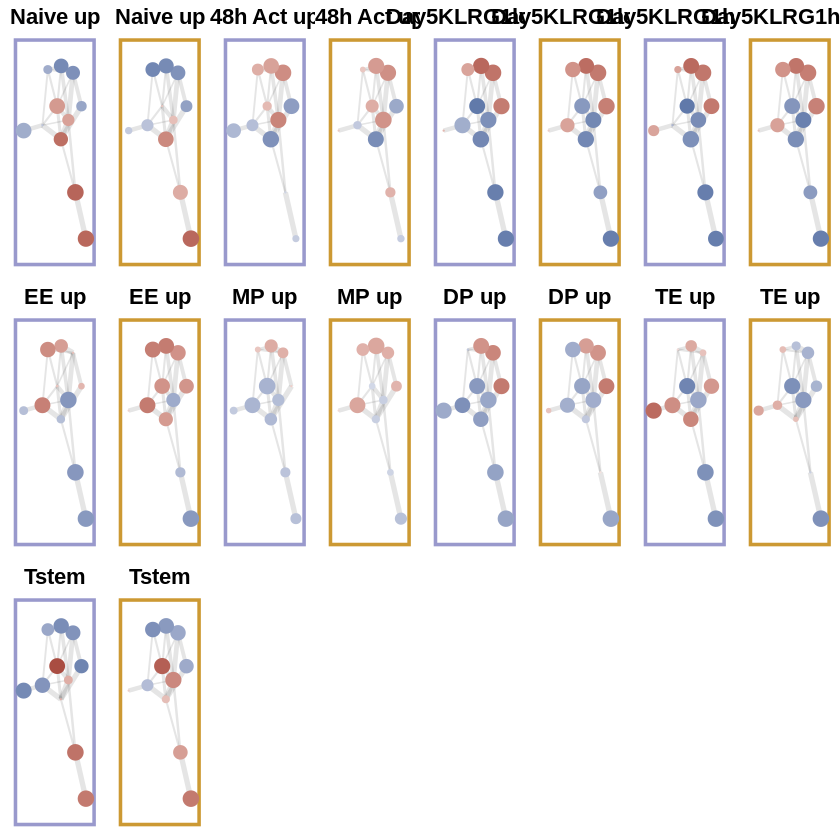

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"

Joining, by = "louvain"



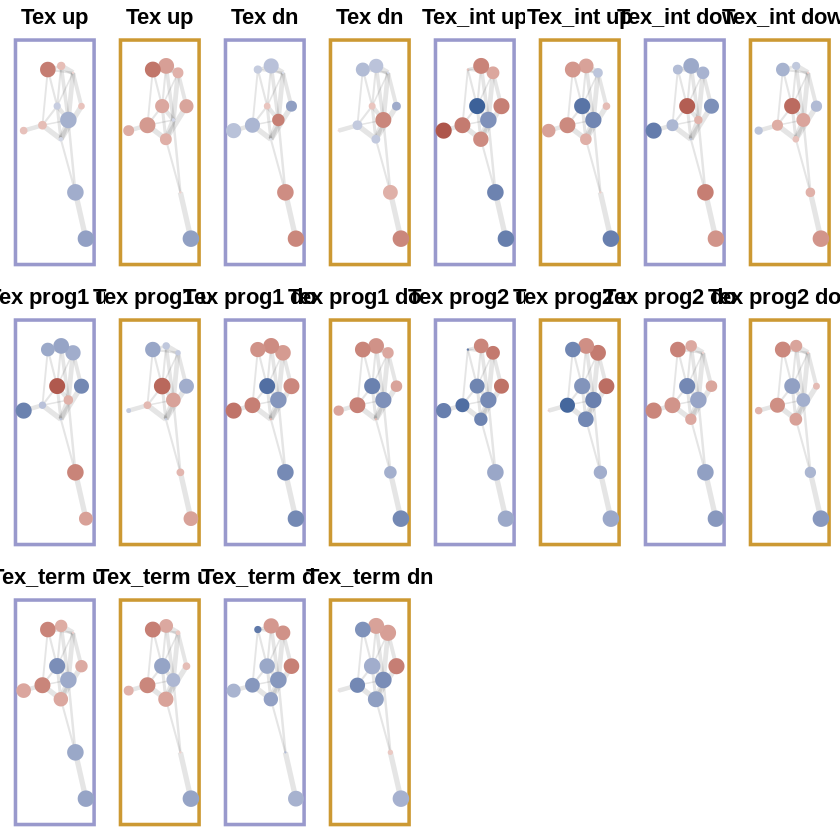

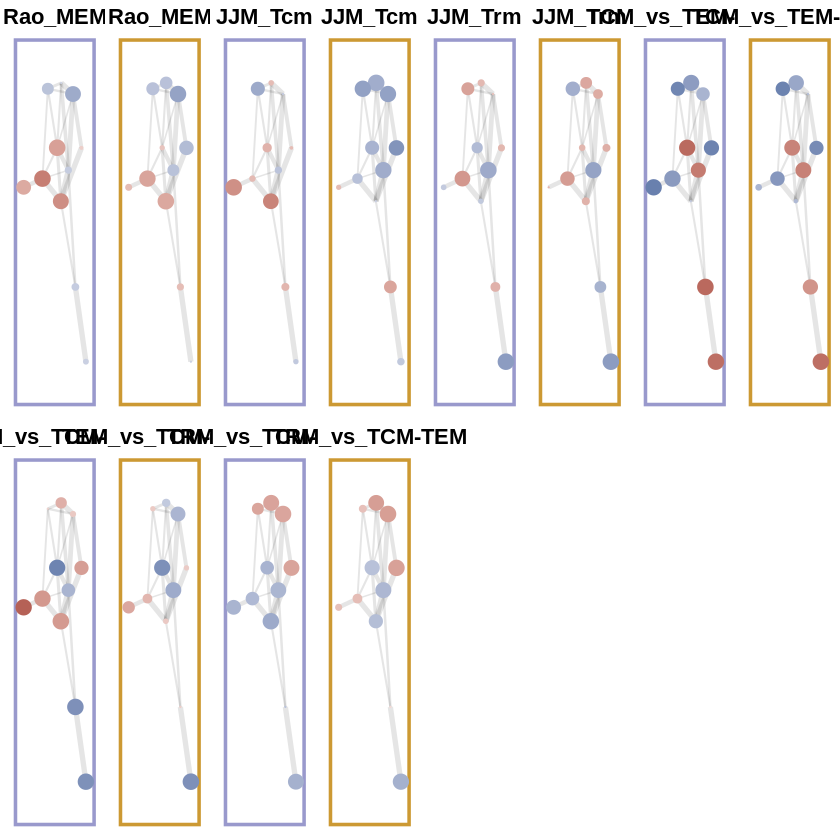

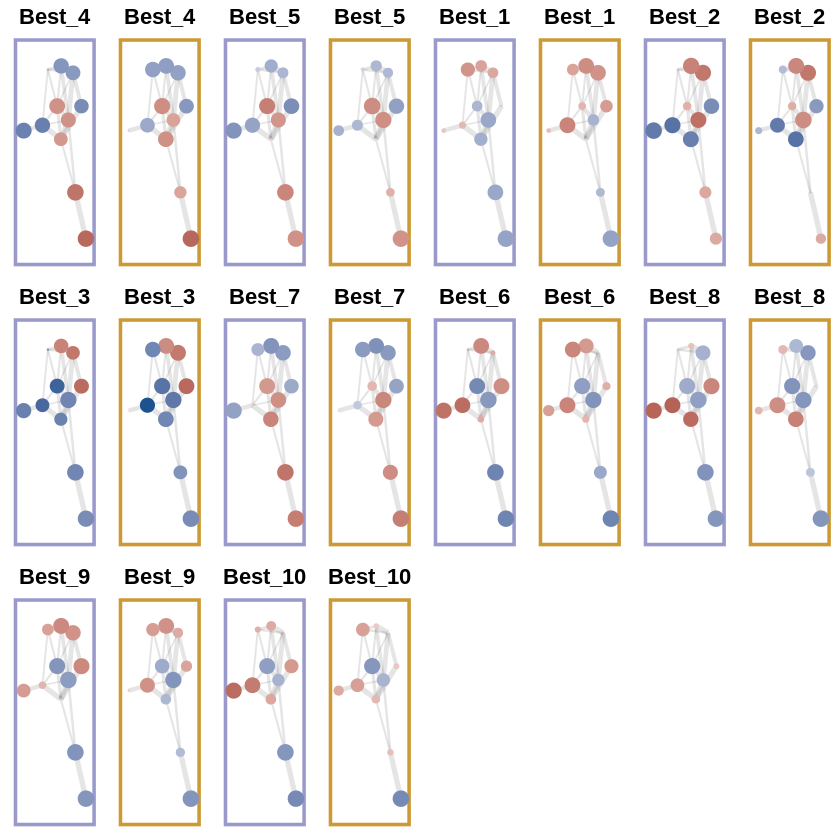

In [16]:
groups <- unique(gs.use.df$plot_use)
for (group in groups){
    gs.use.group.df <- gs.use.df %>% filter(plot_use == group) %>% arrange(order)
    plot.list.ac <- list()
    for (i in c(1:nrow(gs.use.group.df))){
        gs_i <- gs.use.group.df$gs_name[i]
        gs_abbr_i <- gs.use.group.df$abbr[i]

        plot.i.df <- gsea.out.df %>% filter(pathway == gs_i) %>% separate(comparison, c("louvain", "celltype"))
        plot.i.df$nlog10padj <- -log10(plot.i.df$padj)

        plot.i.a.df <- plot.i.df %>% filter(celltype == 'A') %>% select(one_of(c("louvain", "NES", "nlog10padj")))
        colnames(plot.i.a.df) <- c("louvain", "val", "size")
        plot.i.a.df <- paga.pos.tb %>% left_join(plot.i.a.df)

        plot.i.c.df <- plot.i.df %>% filter(celltype == 'C') %>% select(one_of(c("louvain", "NES", "nlog10padj")))
        colnames(plot.i.c.df) <- c("louvain", "val", "size")
        plot.i.c.df <- paga.pos.tb %>% left_join(plot.i.c.df)

        a.plot.i <- conn_plot(plot.i.a.df, paga.conn.tb, gs_abbr_i, "NES" , "white", mute=TRUE) +
            theme(legend.position="none") +  
            theme(panel.background = element_rect(color = "#9999cc", size=2))
        c.plot.i <- conn_plot(plot.i.c.df, paga.conn.tb, gs_abbr_i, "NES" , "white", mute=TRUE) +
            theme(legend.position="none") +
            theme(panel.background = element_rect(color = "#cc9933", size=2))

        plot.list.ac[[paste("Arm", gs_abbr_i, sep="_")]] <- a.plot.i
        plot.list.ac[[paste("Cl13", gs_abbr_i, sep="_")]] <- c.plot.i
    }
    ac.plots <- grid.arrange(grobs=plot.list.ac, ncol=8)
    
    wid = 5*8
    hei = 5.5*ceiling(nrow(gs.use.group.df) / 4)
    ggsave(paste("Arm-Cl13", group, "node_plots", ".png", sep="_"), ac.plots, width=wid, height=hei, units="cm")
}

In [17]:
a.plot.i <- conn_plot(plot.i.a.df, paga.conn.tb, gs_abbr_i, "NES" , "white", mute=TRUE) +
            theme(panel.background = element_rect(color = "#cc9933", size=2))
ggsave("Arm-Cl13_legend_sample.png", a.plot.i, width=10, height=8, units="cm")